## Data Processing Playground
Creating easy-access and modified files

In [25]:
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import gcsfs
from tqdm import tqdm
import cftime
import xesmf as xe

from datetime import datetime as dt
import time
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/srv/conda/envs/notebook'

fs = gcsfs.GCSFileSystem()
fs.ls("gs://leap-persistent-ro/sungdukyu") # List files in the bucket where the E3SM-MMF dataset is stored

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent-ro/sungdukyu/testing']

#### Check which variables are included & their dimensions/shapes 

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).


## Interpolating for Visualization

In [ ]:
#!pip install pyngl
#!pip install pynco

In [6]:
def save_attr_not_levels(ds, attribute, basedir):
    
    mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
    ds_grid = xr.open_dataset(mapper, engine='zarr')

    # original lat and lon info
    lat = ds_grid.lat.values.round(2) 
    lon = ds_grid.lon.values.round(2) 

    # new lat and lon grids that we finally want
    nlat = np.arange(-90, 90.5, 2)
    nlon = np.arange(0, 360, 2)
    
    
    ds = xr.DataArray(ds[attribute], coords = [ds.time, ds.ncol])
    
    ds['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
    ds['lon'] = (('ncol'),lon.T)

    # set multi-index for the original dataset using lat and lon
    ds = ds.set_index(index_id=["lat", "lon"])
    index_id = ds.index_id
    ds = ds.drop('index_id')
    ds = ds.rename({'ncol':'index_id'})
    ds = ds.assign_coords(index_id = index_id)
    
    ds_new = xr.Dataset(
         data_vars={
             attribute: (("time","lat","lon"), np.zeros([len(ds.time), len(nlat), len(nlon)]))
         },
         coords={
             "time": ds.time,
             "lat": nlat,
             "lon": nlon,
            # "lev": ds.lev,
        },
    )

    for it, tt in enumerate(ds.time):
        if(it % 500 == 0):
            print(it)
        data = ds.sel(time=tt).values # lat lon grid, but not formatted
        ds_new[attribute][it,:] =  Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze() # same data
    
    ds_new.to_netcdf(os.path.join(basedir, attribute + "_saved.nc"))

    #return(ds_new)



### Loading Input Variables

In [7]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds = xr.open_dataset(mapper, engine='zarr')
ds

<xarray.Dataset>
Dimensions:           (sample: 210240, ncol: 384, lev: 60)
Dimensions without coordinates: sample, ncol, lev
Data variables: (12/29)
    cam_in_ALDIF      (sample, ncol) float64 ...
    cam_in_ALDIR      (sample, ncol) float64 ...
    cam_in_ASDIF      (sample, ncol) float64 ...
    cam_in_ASDIR      (sample, ncol) float64 ...
    cam_in_ICEFRAC    (sample, ncol) float64 ...
    cam_in_LANDFRAC   (sample, ncol) float64 ...
    ...                ...
    state_q0003       (sample, lev, ncol) float64 ...
    state_t           (sample, lev, ncol) float64 ...
    state_u           (sample, lev, ncol) float64 ...
    state_v           (sample, lev, ncol) float64 ...
    tod               (sample) int32 ...
    ymd               (sample) int32 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [8]:
time = pd.DataFrame({"ymd":ds.ymd, "tod":ds.tod})
ds = ds.drop(['tod','ymd'])
f = lambda ymd, tod : cftime.DatetimeNoLeap(ymd//10000, ymd%10000//100, ymd%10000%100, tod // 3600, tod%3600 // 60)
time = time.apply(lambda x: f(x.ymd, x.tod), axis=1)
ds['sample'] = list(time)
ds = ds.rename({'sample':'time'})

ds = ds.isel(time = np.arange(36,len(ds.time),72)) #  every 1 day
ds

<xarray.Dataset>
Dimensions:           (time: 2920, ncol: 384, lev: 60)
Coordinates:
  * time              (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
Dimensions without coordinates: ncol, lev
Data variables: (12/27)
    cam_in_ALDIF      (time, ncol) float64 ...
    cam_in_ALDIR      (time, ncol) float64 ...
    cam_in_ASDIF      (time, ncol) float64 ...
    cam_in_ASDIR      (time, ncol) float64 ...
    cam_in_ICEFRAC    (time, ncol) float64 ...
    cam_in_LANDFRAC   (time, ncol) float64 ...
    ...                ...
    state_q0001       (time, lev, ncol) float64 ...
    state_q0002       (time, lev, ncol) float64 ...
    state_q0003       (time, lev, ncol) float64 ...
    state_t           (time, lev, ncol) float64 ...
    state_u           (time, lev, ncol) float64 ...
    state_v           (time, lev, ncol) float64 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [54]:
attrs = []
attrs_level = []
for var in ds.data_vars:
    if 'lev' in ds[var].dims:
        attrs_level.append(var)
    else:
        attrs.append(var)
attrs_level

['pbuf_CH4',
 'pbuf_N2O',
 'pbuf_ozone',
 'state_pmid',
 'state_q0001',
 'state_q0002',
 'state_q0003',
 'state_t',
 'state_u',
 'state_v']

In [ ]:
for attribute in attrs:
    save_attr_not_levels(ds, attribute, 'saved_data/input')

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
1250
2250
2500


In [61]:
attrs

['cam_in_ALDIF',
 'cam_in_ALDIR',
 'cam_in_ASDIF',
 'cam_in_ASDIR',
 'cam_in_ICEFRAC',
 'cam_in_LANDFRAC',
 'cam_in_LWUP',
 'cam_in_OCNFRAC',
 'cam_in_SNOWHICE',
 'cam_in_SNOWHLAND',
 'pbuf_COSZRS',
 'pbuf_LHFLX',
 'pbuf_SHFLX',
 'pbuf_SOLIN',
 'pbuf_TAUX',
 'pbuf_TAUY',
 'state_ps']

### Loading Output Variables

In [62]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds = xr.open_dataset(mapper, engine='zarr')

time = pd.DataFrame({"ymd":ds.ymd, "tod":ds.tod})
ds = ds.drop(['tod','ymd'])
f = lambda ymd, tod : cftime.DatetimeNoLeap(ymd//10000, ymd%10000//100, ymd%10000%100, tod // 3600, tod%3600 // 60)
time = time.apply(lambda x: f(x.ymd, x.tod), axis=1)
ds['sample'] = list(time)
ds = ds.rename({'sample':'time'})

itime = np.arange(36,len(ds.time),72) # every 1 day
ds = ds.isel(time = itime)

attrs = ['cam_out_FLWDS', 'cam_out_NETSW', 'cam_out_PRECC', 'cam_out_PRECSC', 'cam_out_SOLL',
     'cam_out_SOLLD', 'cam_out_SOLS', 'cam_out_SOLSD']
for i in [1, 2, 3, 4, 5, 6, 7]:
    ds_new = save_attr_not_levels(ds, attrs[i], 'saved_data/output')

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
0
250
2750


In [20]:
attrs = ['cam_out_FLWDS', 'cam_out_NETSW', 'cam_out_PRECC', 'cam_out_PRECSC', 'cam_out_SOLL',
     'cam_out_SOLLD', 'cam_out_SOLS', 'cam_out_SOLSD']
for i in [1, 2, 3, 4, 5, 6, 7]:
    ds_new = save_attr_not_levels(ds, attrs[i], 'saved_data/output')

In [ ]:
xr.open_dataset('saved_data/output/cam_out_NETSW_saved.nc')

In [ ]:
attrs_levels = [ 'state_q0001', 'state_q0002', 'state_q0003', 'state_t', 'state_u', 'state_v' ]

def save_levels_attr(ds, attribute):
    ncol = ds.ncol.values
    levels = ds.lev.values
    ds = xr.DataArray(ds[attribute], coords = [ds.time, ncol, levels])
    
    ds_new = xr.Dataset(
         data_vars={
             attribute: (("time","lat","lon", 'levels'), np.zeros([len(ds.time), len(nlat), len(nlon)]))
         },
         coords={
             "time": ds.time,
             "lat": nlat,
             "lon": nlon,
            # "lev": ds.lev,
        },
    )

## Loading Saved Files into Datasets

In [12]:
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import cftime
import gcsfs
fs = gcsfs.GCSFileSystem()
import os

In [13]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds = xr.open_dataset(mapper, engine='zarr')
all_input_vars = list(ds.data_vars)[:-2]

mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds = xr.open_dataset(mapper, engine='zarr')
all_output_vars = list(ds.data_vars)[:-2]

In [14]:
print(all_input_vars)
print("\n\n", all_output_vars)

['cam_in_ALDIF', 'cam_in_ALDIR', 'cam_in_ASDIF', 'cam_in_ASDIR', 'cam_in_ICEFRAC', 'cam_in_LANDFRAC', 'cam_in_LWUP', 'cam_in_OCNFRAC', 'cam_in_SNOWHICE', 'cam_in_SNOWHLAND', 'pbuf_CH4', 'pbuf_COSZRS', 'pbuf_LHFLX', 'pbuf_N2O', 'pbuf_SHFLX', 'pbuf_SOLIN', 'pbuf_TAUX', 'pbuf_TAUY', 'pbuf_ozone', 'state_pmid', 'state_ps', 'state_q0001', 'state_q0002', 'state_q0003', 'state_t', 'state_u', 'state_v']


 ['cam_out_FLWDS', 'cam_out_NETSW', 'cam_out_PRECC', 'cam_out_PRECSC', 'cam_out_SOLL', 'cam_out_SOLLD', 'cam_out_SOLS', 'cam_out_SOLSD', 'state_q0001', 'state_q0002', 'state_q0003', 'state_t', 'state_u', 'state_v']


In [3]:
def load_dataset_interp(input_vars, output_vars):
    basedir = "saved_data/input"
    dataset = xr.open_dataset(os.path.join(basedir, input_vars[0] + "_saved.nc"))
    for var in input_vars[1:]:
        ds = xr.open_dataset(os.path.join(basedir, var + "_saved.nc"))
        dataset[var] = ds[var]
        
    basedir = "saved_data/output"
    for var in output_vars:
        ds = xr.open_dataset(os.path.join(basedir, var + "_saved.nc"))
        dataset[var] = ds[var]
    return(dataset)

## Loading Data: zarr --> xarray

In [2]:
input_vars = ['cam_in_ASDIR', 'pbuf_LHFLX', 'state_q0001']
output_vars = ['cam_out_NETSW', 'cam_out_PRECC', 'state_q0001']

In [11]:
def load_vars_xarray(input_vars, output_vars, downsample=True, chunks = False):
    # raw files, not interpolated according to Yu suggestion
    if(chunks):
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
        inp = xr.open_dataset(mapper, engine='zarr', chunks={})
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
        output = xr.open_dataset(mapper, engine='zarr', chunks={})
    else:
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
        inp = xr.open_dataset(mapper, engine='zarr')
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
        output = xr.open_dataset(mapper, engine='zarr')
    if downsample: # might as well do first
        inp = inp.isel(sample = np.arange(36,len(inp.sample),72)) #  every 1 day
        output = output.isel(sample = np.arange(36,len(output.sample),72))
    ds = inp[input_vars]
    for var in output_vars:
        ds['out_'+var] = output[var]

    time = pd.DataFrame({"ymd":inp.ymd, "tod":inp.tod})
    # rename sample to reformatted time column 
    f = lambda ymd, tod : cftime.DatetimeNoLeap(ymd//10000, ymd%10000//100, ymd%10000%100, tod // 3600, tod%3600 // 60)
    time = time.apply(lambda x: f(x.ymd, x.tod), axis=1)
    ds['sample'] = list(time)
    ds = ds.rename({'sample':'time'})
    ds = ds.assign_coords({'ncol' : ds.ncol})
    return(ds)

In [7]:
def split_vars(var_list, out=False):
    v = []
    leveled = []
    for var in var_list:
        if out:
            var = 'out_' + var
        if(len(ds[var].shape) > 2):
            leveled.append(var)
        else:
            v.append(var)
    return(v, leveled)

def split_input_output(ds):
    inp = []
    out = []
    for var in ds.data_vars:
        if(var[:3] == 'out'):
            out.append(var)
        else:
            inp.append(var)
    return(ds[inp], ds[out])

In [8]:
ds = load_vars_xarray(input_vars, output_vars)
X, Y = split_input_output(ds)
X

<xarray.Dataset>
Dimensions:       (time: 2920, ncol: 384, lev: 60)
Coordinates:
  * time          (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol          (ncol) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Dimensions without coordinates: lev
Data variables:
    cam_in_ASDIR  (time, ncol) float64 dask.array<chunksize=(21, 384), meta=np.ndarray>
    pbuf_LHFLX    (time, ncol) float64 dask.array<chunksize=(21, 384), meta=np.ndarray>
    state_q0001   (time, lev, ncol) float64 dask.array<chunksize=(21, 60, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [9]:
reg_vars, leveled_vars = split_vars(input_vars)
reg_vars, leveled_vars

(['cam_in_ASDIR', 'pbuf_LHFLX'], ['state_q0001'])

#### Generalization testing: splitting by region

In [9]:
def load_latlon():
    mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
    ds_grid = xr.open_dataset(mapper, engine='zarr')
    lat = ds_grid.lat.values.round(2) 
    lon = ds_grid.lon.values.round(2)  
    return(lat, lon)
lat, lon = load_latlon()
print(list(zip(lat, lon))[:5])

f = lambda row : row.lat > 50

def select_region(condition):
    # assumes condition is a lambda function taking in a lat and lon
    # returns the indices for which this is true
    lat, lon = load_latlon()
    latlon = pd.DataFrame({"lat" : lat, "lon": lon})
    return(list(latlon[latlon.apply(condition, axis=1)].index))

def split_ds_by_area(ds, condition):
    match = select_region(condition)
    unmatch = select_region(lambda row : not condition(row))
    return(ds.isel(ncol=match), ds.isel(ncol=unmatch))

[(-32.59, 320.27), (-35.99, 331.53), (-22.69, 320.44), (-25.37, 331.69), (-38.2, 342.98)]


In [192]:
lat, lon = load_latlon()

f = lambda row : row.lat > 50
train, test = split_ds_by_area(ds, f)

In [10]:
def add_index_id(ds):
    lat, lon = load_latlon()
    ds['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
    ds['lon'] = (('ncol'),lon.T)
    
    ds['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
    ds['lon'] = (('ncol'),lon.T)

    # set multi-index for the original dataset using lat and lon
    ds = ds.set_index(index_id=["lat", "lon"])
    index_id = ds.index_id
    ds = ds.drop(['index_id', 'lat', 'lon'])
    ds = ds.rename({'ncol':'index_id'})
    ds = ds.assign_coords(index_id = index_id)
    
    
    return(ds)

In [14]:
add_index_id(load_vars_xarray(input_vars, output_vars))

<xarray.Dataset>
Dimensions:            (time: 2920, index_id: 384, lev: 60)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * index_id           (index_id) object MultiIndex
  * lat                (index_id) float64 -32.59 -35.99 -22.69 ... 45.34 40.39
  * lon                (index_id) float64 320.3 331.5 320.4 ... 146.7 135.0
Dimensions without coordinates: lev
Data variables:
    cam_in_ASDIR       (time, index_id) float64 dask.array<chunksize=(21, 384), meta=np.ndarray>
    pbuf_LHFLX         (time, index_id) float64 dask.array<chunksize=(21, 384), meta=np.ndarray>
    state_q0001        (time, lev, index_id) float64 dask.array<chunksize=(21, 60, 384), meta=np.ndarray>
    out_cam_out_NETSW  (time, index_id) float64 dask.array<chunksize=(21, 384), meta=np.ndarray>
    out_cam_out_PRECC  (time, index_id) float64 dask.array<chunksize=(21, 384), meta=np.ndarray>
    out_state_q0001    (time, lev, index_id) float64 dask.array<chunksize=(21, 60, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

## The Problem - loading levels variables

In [ ]:
humidity = ds['state_q0001'].data

### ... crashes the kernel with > 30 GB 

# Batching

In [19]:
ds.dims

Frozen({'time': 2920, 'ncol': 384, 'lev': 60})

## Manual Batching

In [ ]:
max_i = ds.time.size * ds.ncol.size # number of vectors in S
print(max_i)
import random
i = random.randrange(0, max_i) # randint is inclusive, but cannot actually have 
i

In [9]:
def get_item(ds, index):
    # t * ds.ncol.size + col == i
    # given an index, wrap around (time x ncol) grid selecting specific variable
    # converting linear indexing into structured
    assert index < ds.time.size * ds.ncol.size, "Index is outside of range"
    t, col = index // ds.ncol.size, index % ds.ncol.size
    return(ds.isel(time=t, ncol=col))

In [ ]:
%%time
get_item(ds, max_i-1)

In [8]:
def get_batch(ds, batch_num, batch_size = 32, dim = 'ncol'):
    #same kind of linear index interpretation, except over a batch size
    # doing over ncol because 384 = 3 * 2**7, which splits nicely over powers of 2
    n_batch = ds[dim].size / batch_size
    other_dim_batch, dim_batch = int(batch_num // n_batch), batch_num % n_batch
    start, stop = int(dim_batch * batch_size), int((dim_batch+1) * batch_size)
    if(dim == 'ncol'):
        print(f"ncol from {start}-{stop}; time={other_dim_batch}")
        return(ds.isel(ncol=slice(start, stop), time=other_dim_batch))
    elif(dim=='time'):
        return(ds.isel(time=slice(start, stop), ncol=other_dim_batch))

In [ ]:
%%time
get_batch(ds, 345)

## Dask -  Xarray Built in Chunking

In [14]:
input_vars = ['cam_in_ASDIR', 'pbuf_LHFLX', 'state_q0001']
output_vars = ['cam_out_NETSW', 'cam_out_PRECC', 'state_q0001']
ds = load_vars_xarray(input_vars, output_vars)

In [15]:
chunks = ds.chunk(chunks={'time':292, 'ncol' : 384})

In [16]:
chunks

<xarray.Dataset>
Dimensions:            (time: 2920, ncol: 384, lev: 60)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 ... 378 379 380 381 382 383
Dimensions without coordinates: lev
Data variables:
    cam_in_ASDIR       (time, ncol) float64 dask.array<chunksize=(292, 384), meta=np.ndarray>
    pbuf_LHFLX         (time, ncol) float64 dask.array<chunksize=(292, 384), meta=np.ndarray>
    state_q0001        (time, lev, ncol) float64 dask.array<chunksize=(292, 60, 384), meta=np.ndarray>
    out_cam_out_NETSW  (time, ncol) float64 dask.array<chunksize=(292, 384), meta=np.ndarray>
    out_cam_out_PRECC  (time, ncol) float64 dask.array<chunksize=(292, 384), meta=np.ndarray>
    out_state_q0001    (time, lev, ncol) float64 dask.array<chunksize=(292, 60, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Playing with Dask arrays

In [17]:
arr = ds.cam_in_ASDIR.data
arr

dask.array<getitem, shape=(2920, 384), dtype=float64, chunksize=(21, 384), chunktype=numpy.ndarray>

In [18]:
arr.chunksize # largest

(21, 384)

In [19]:
str(arr.chunks[0][:5]) + "...", arr.chunks[1]

('(21, 21, 21, 21, 21)...', (384,))

In [20]:
print(np.array_equal(arr.blocks[4].compute(), arr.blocks[4, 0].compute())) # 1d list
arr.blocks[4]

True


dask.array<blocks, shape=(21, 384), dtype=float64, chunksize=(21, 384), chunktype=numpy.ndarray>

In [21]:
import sys

In [22]:
block = arr.blocks[4]
sys.getsizeof(block) # bytes

80

In [23]:
print(sys.getsizeof(block.compute()))
print(sys.getsizeof(block))

64640
80


In [24]:
sys.getsizeof(ds)

112

### Reshaping chunks into batches

In [15]:
chunks.cam_in_ASDIR[i].compute().data.reshape(1, 384)

array([[0.02816712, 0.02510547, 0.03156327, 0.02387966, 0.02412138,
        0.02394217, 0.02364987, 0.02380127, 0.02421444, 0.030226  ,
        0.02365209, 0.10182889, 0.03268689, 0.03584835, 0.05786161,
        0.03553196, 0.03309982, 0.02369681, 0.03414739, 0.02388407,
        0.02393339, 0.02438262, 0.02375599, 0.02412281, 0.02408521,
        0.05192224, 0.02405612, 0.03268469, 0.03939821, 0.04000316,
        0.03840545, 0.04727887, 0.02991925, 0.02500807, 0.03494465,
        0.02861837, 0.02472151, 0.0338869 , 0.0929256 , 0.17697516,
        0.04050325, 0.04356853, 0.18773306, 0.27980128, 0.052407  ,
        0.08356952, 0.16733528, 0.09361991, 0.04442774, 0.03729055,
        0.06151345, 0.05481403, 0.04137992, 0.23732347, 0.05176454,
        0.05959637, 0.2935918 , 0.29158346, 0.08267393, 0.05360969,
        0.31456987, 0.15628449, 0.06010334, 0.22942705, 0.0510359 ,
        0.08031846, 0.04980996, 0.08132186, 0.13285718, 0.23538925,
        0.14292933, 0.27665523, 0.38877513, 1.  

In [37]:
%%time
chunks.state_q0001[10].compute()

CPU times: user 799 ms, sys: 426 ms, total: 1.22 s
Wall time: 1.38 s


<xarray.DataArray 'state_q0001' (lev: 60, index_id: 384)>
array([[1.50291778e-06, 1.49576035e-06, 1.50713043e-06, ...,
        1.45233874e-06, 1.46039008e-06, 1.46049212e-06],
       [1.46497259e-06, 1.47401435e-06, 1.47336352e-06, ...,
        1.42486168e-06, 1.41597325e-06, 1.42422200e-06],
       [1.43503168e-06, 1.46096724e-06, 1.43268617e-06, ...,
        1.36356822e-06, 1.36140361e-06, 1.36630619e-06],
       ...,
       [1.43757711e-02, 1.19685098e-02, 1.56515271e-02, ...,
        2.08943683e-03, 1.92376675e-03, 3.62283988e-03],
       [1.51771923e-02, 1.22960318e-02, 1.56855599e-02, ...,
        2.17888843e-03, 1.94796894e-03, 3.67481551e-03],
       [1.54905168e-02, 1.25326292e-02, 1.57139704e-02, ...,
        2.24241565e-03, 1.97449077e-03, 3.70173029e-03]])
Coordinates:
    time      object 0001-02-11 12:00:00
  * lat       (index_id) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
  * lon       (index_id) float64 320.3 331.5 320.4 331.7 ... 123.3 146.7 135.0
  * index_id  (index_id) object MultiIndex
Dimensions without coordinates: lev

In [27]:
%%time
i = 10
dimvars = []
for var in reg_vars:
    dimvars.append(chunks[var][i].compute().data.reshape(1, 384))
for var in leveled_vars:
    dimvars.append(chunks[var][i].compute().data)

CPU times: user 7.59 s, sys: 4.54 s, total: 12.1 s
Wall time: 11.5 s


In [28]:
%%time
batch = np.concatenate(dimvars, axis=0)
batch.shape

CPU times: user 136 µs, sys: 0 ns, total: 136 µs
Wall time: 107 µs


(62, 384)

In [95]:
len(chunks.state_q0001)

2920

In [21]:
def to_array(ds):
    dims = []
    for var in ds.data_vars:
        arr = ds[var].values
        if('lev' in ds[var].dims):
            arr = arr.reshape(arr.shape[0] * arr.shape[1], -1)
        dims.append(arr)
    return(np.vstack(dims))

In [25]:
i = 1012 # select the i'th input vector

In [ ]:
%%time
to_array(a)[:10] # this takes 2.5 seconds the first time for new i, then fast

So now just have to figure out a way to turn that same operation fast *the first time*

## XBatcher 
- seems too slow to be worth using. 2 seconds to load batch!

In [8]:
#! pip install xbatcher

In [9]:
import xbatcher

In [10]:
bgen = xbatcher.BatchGenerator(ds, {'time' : 1, 'index_id' : 1})
len(bgen)

1121280

In [11]:
%%time
bgen[5]

CPU times: user 1.88 s, sys: 1.15 s, total: 3.03 s
Wall time: 4.67 s


<xarray.Dataset>
Dimensions:            (time: 1, index_id: 1, lev: 60)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00
  * lat                (index_id) float64 -39.26
  * lon                (index_id) float64 354.3
  * index_id           (index_id) object MultiIndex
Dimensions without coordinates: lev
Data variables:
    cam_in_ASDIR       (time, index_id) float64 0.02367
    pbuf_LHFLX         (time, index_id) float64 15.95
    state_q0001        (time, lev, index_id) float64 1.526e-06 ... 0.009254
    out_cam_out_NETSW  (time, index_id) float64 701.5
    out_cam_out_PRECC  (time, index_id) float64 6.519e-10
    out_state_q0001    (time, lev, index_id) float64 1.526e-06 ... 0.00921
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [ ]:
%%time
np.array_equal(to_array(ds.isel(time=[i//384], index_id=[i%384])), to_array(bgen[i]))

In [16]:
# TO DO - optimize this function
# WHY IS THIS SO SLOOWWWW
# weird observation - super slow the first time I run it, and then super fast
# caching?
def to_array(ds):
    dims = []
    for var in ds.data_vars:
        arr = ds[var].values
        if('lev' in ds[var].dims):
            arr = arr.reshape(arr.shape[0] * arr.shape[1], -1)
        dims.append(arr)
    return(np.vstack(dims))

In [12]:
a = bgen[0]
a

<xarray.Dataset>
Dimensions:            (time: 1, index_id: 1, lev: 60)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00
  * lat                (index_id) float64 -32.59
  * lon                (index_id) float64 320.3
  * index_id           (index_id) object MultiIndex
Dimensions without coordinates: lev
Data variables:
    cam_in_ASDIR       (time, index_id) float64 0.0271
    pbuf_LHFLX         (time, index_id) float64 78.17
    state_q0001        (time, lev, index_id) float64 1.484e-06 ... 0.01039
    out_cam_out_NETSW  (time, index_id) float64 834.6
    out_cam_out_PRECC  (time, index_id) float64 0.0
    out_state_q0001    (time, lev, index_id) float64 1.484e-06 ... 0.01039
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [18]:
to_array(a)[:5]

array([[2.71048431e-02],
       [7.81690274e+01],
       [1.48405146e-06],
       [1.47363811e-06],
       [1.45253578e-06]])

In [19]:
def generator():
    bgen = xbatcher.BatchGenerator(ds, {'time' : 1, 'index_id' : 1})
    i = 0
    n = len(ds.time) * len(ds.index_id)
    while True:
        batch = bgen[i]
        X, Y = split_dataset(batch)
        yield to_array(X).T, to_array(Y).T

In [20]:
gen = generator()
next(iter(gen))

In [21]:
next(iter(gen))

(array([[2.71048431e-02, 7.81690274e+01, 1.48405146e-06, 1.47363811e-06,
         1.45253578e-06, 1.43923459e-06, 1.42809350e-06, 1.43393789e-06,
         1.44471159e-06, 1.41513459e-06, 1.40821652e-06, 1.39907270e-06,
         1.28333605e-06, 1.20348524e-06, 1.20333755e-06, 1.21499521e-06,
         1.25639743e-06, 1.28150990e-06, 1.28213903e-06, 1.29173556e-06,
         1.84984366e-06, 3.05114717e-06, 5.33372938e-06, 8.88570824e-06,
         1.43279327e-05, 2.21970669e-05, 3.13894203e-05, 5.27034580e-05,
         8.17120427e-05, 1.28736286e-04, 1.87419785e-04, 2.60236083e-04,
         3.56258148e-04, 4.69132004e-04, 6.06379703e-04, 7.67025518e-04,
         9.16353114e-04, 1.02838050e-03, 1.13318173e-03, 1.29179811e-03,
         1.48377044e-03, 1.68818042e-03, 2.11423266e-03, 2.44678262e-03,
         2.88127240e-03, 2.93212608e-03, 3.24649150e-03, 3.68400181e-03,
         4.10138807e-03, 4.95822082e-03, 6.21226164e-03, 7.12951424e-03,
         7.69293488e-03, 8.27272148e-03, 9.13267695

In [256]:
import xbatcher
bgen = xbatcher.BatchGenerator(ds, {'time' : 1, 'index_id' : 1})
def to_array(ds):
    dims = []
    for var in ds.data_vars:
        arr = ds[var].values
        if('lev' in ds[var].dims):
            arr = arr.reshape(arr.shape[0] * arr.shape[1], -1)
        dims.append(arr)
    return(np.vstack(dims))

def generator():
    bgen = xbatcher.BatchGenerator(ds, {'time' : 1, 'index_id' : 1})
    i = 0
    n = len(ds.time) * len(ds.index_id)
    while True:
        batch = bgen[i]
        X, Y = split_dataset(batch)
        yield to_array(X).T, to_array(Y).T

# Formatting For ML Pipeline

## Batches into Arrays - bottleneck right now!

In [12]:
ds = load_vars_xarray(input_vars, output_vars, chunks=False)
batch = get_batch(ds, 0, batch_size=)

X, Y = split_input_output(batch)
batch

ncol from 0-32; time=0


<xarray.Dataset>
Dimensions:            (ncol: 32, lev: 60)
Coordinates:
    time               object 0001-02-01 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
Dimensions without coordinates: lev
Data variables:
    cam_in_ASDIR       (ncol) float64 ...
    pbuf_LHFLX         (ncol) float64 ...
    state_q0001        (lev, ncol) float64 ...
    out_cam_out_NETSW  (ncol) float64 ...
    out_cam_out_PRECC  (ncol) float64 ...
    out_state_q0001    (lev, ncol) float64 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [ ]:
arr = X.to_stacked_array("v", sample_dims=["ncol"])
arr.shape

### Testing on synthetic dataset - very fast!!

In [55]:
np.random.seed(0)

In [72]:
temp = 15 + 8 * np.random.randn(32, 1, 60)
precipitation = 0.5 * np.random.rand(32, 1, 60)
humidity = np.random.rand(32, 1, 60)
ncol = np.arange(32)
levs = np.arange(60)

In [77]:
ds = xr.Dataset(
    data_vars = dict(
        temp = (['ncol', 'time', 'lev'], temp),
        prec = (['ncol', 'time', 'lev'], precipitation),
        hum = (['ncol', 'time', 'lev'], humidity),
    ),
    coords = {'ncol' : ('ncol', ncol), 'time' : ('time', [8]), 'lev' : ('lev', levs)}
)

ds

<xarray.Dataset>
Dimensions:  (ncol: 32, time: 1, lev: 60)
Coordinates:
  * ncol     (ncol) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * time     (time) int64 8
  * lev      (lev) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
Data variables:
    temp     (ncol, time, lev) float64 21.73 21.86 21.56 ... 10.83 19.25 21.43
    prec     (ncol, time, lev) float64 0.2923 0.1311 0.4003 ... 0.478 0.08552
    hum      (ncol, time, lev) float64 0.1996 0.1493 0.2 ... 0.521 0.5623 0.9621

In [78]:
%%time
ds.to_stacked_array('vars', sample_dims=['ncol'])

CPU times: user 14.1 ms, sys: 0 ns, total: 14.1 ms
Wall time: 13.7 ms


<xarray.DataArray 'temp' (ncol: 32, vars: 180)>
array([[2.17312063e+01, 2.18597254e+01, 2.15559911e+01, ...,
        1.65253434e-01, 7.18746362e-01, 1.04664004e-01],
       [8.51052346e+00, 2.04665402e+01, 1.77452134e+01, ...,
        4.69902557e-01, 3.22480064e-01, 8.80742088e-01],
       [2.81498255e+01, 1.82832183e+01, 9.56702599e+00, ...,
        5.90568200e-02, 1.83315359e-01, 4.09449472e-01],
       ...,
       [2.08161756e+01, 2.97609973e+01, 3.38493406e+00, ...,
        2.38439549e-01, 1.67362089e-02, 6.91066005e-01],
       [1.09815910e+01, 5.17770973e+00, 2.22388208e+01, ...,
        2.99531070e-01, 4.54315208e-01, 9.02281900e-01],
       [1.45097133e+01, 1.37776061e+01, 2.94218818e+01, ...,
        5.21018718e-01, 5.62260773e-01, 9.62051810e-01]])
Coordinates:
  * ncol      (ncol) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * vars      (vars) object MultiIndex
  * variable  (vars) object 'temp' 'temp' 'temp' 'temp' ... 'hum' 'hum' 'hum'
  * time      (vars) int64 8 8 8 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8 8 8 8
  * lev       (vars) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59

### Testing effect of different batch sizes

In [18]:
batch_sizes = [1, 2, 4, 8, 32, 64, 128, 384]
batches = dict([(i, get_batch(ds, i, i)) for i in batch_sizes])

ncol from 1-2; time=0
ncol from 4-6; time=0
ncol from 16-20; time=0
ncol from 64-72; time=0
ncol from 256-288; time=2
ncol from 256-320; time=10
ncol from 256-384; time=42
ncol from 0-384; time=384


In [27]:
sizes = []
durations = []
for size, batch in batches.items():
    then = time.time()
    X, Y = split_input_output(batch)
    X = X.to_stacked_array("v", sample_dims=["ncol"])
    Y = Y.to_stacked_array("v", sample_dims=["ncol"])
    print(X.data.shape, Y.data.shape)
    durations.append(time.time() - then)
    sizes.append(size)

(1, 62) (1, 62)
(2, 62) (2, 62)
(4, 62) (4, 62)
(8, 62) (8, 62)
(32, 62) (32, 62)
(64, 62) (64, 62)
(128, 62) (128, 62)
(384, 62) (384, 62)


In [30]:
print(durations)

[2.9804210662841797, 2.5536274909973145, 2.8177051544189453, 2.6688060760498047, 3.2860898971557617, 2.922091007232666, 3.961699962615967, 4.082156658172607]


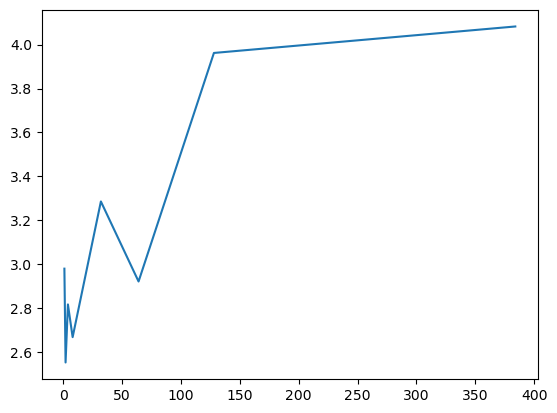

In [28]:
plt.plot(sizes, durations)

### Testing effect of CPU versus GPU

CPU RESULTS : 
7/10, 11:40 PM. 32 Gigabytes

In [40]:
durations = [2.9804210662841797, 2.5536274909973145, 2.8177051544189453, 2.6688060760498047, 3.2860898971557617, 2.922091007232666, 3.961699962615967, 4.082156658172607]
list(zip(batch_sizes, np.round(durations, 2)    ))

[(1, 2.98),
 (2, 2.55),
 (4, 2.82),
 (8, 2.67),
 (32, 3.29),
 (64, 2.92),
 (128, 3.96),
 (384, 4.08)]

GPU RESULTS : 

#### TO DO - optimize GPU usage. How does one do that?
https://pytorch.org/docs/stable/notes/cuda.html#memory-management

## Torch

In [34]:
import torch
from torch import nn

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### Pytorch Input: (n x in_dim )

In [65]:
class TestNetwork(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, out_size),
        )
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def forward(self, x):
        if(type(x) == np.ndarray):
            x = torch.tensor(x_num, device=self.device, dtype=torch.float32)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [66]:
in_size = 62
out_size = 5
model = TestNetwork(in_size, out_size).to(device)
print(model)

TestNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=62, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)


In [75]:
n = 7
x_num = np.random.randn(n, in_size)
x_num.shape

(7, 62)

In [76]:
model(x_num) 

tensor([[ 0.0043,  0.1643, -0.0358,  0.0302, -0.0288],
        [ 0.0348,  0.2901,  0.0552,  0.1344, -0.0559],
        [-0.0146,  0.1368,  0.0327,  0.1166, -0.1762],
        [-0.0439,  0.1754,  0.0120,  0.1793, -0.2282],
        [-0.0150,  0.1671,  0.0046,  0.0926, -0.1531],
        [ 0.0013,  0.0445, -0.0352,  0.1086, -0.0470],
        [-0.0314,  0.0519, -0.0567,  0.2200, -0.0184]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### Pytorch Dataset and Dataloader

In [99]:
from torch.utils.data import Dataset, DataLoader

In [97]:
# USING DASK AND CHUNKS

In [147]:
split_vars(output_vars, out=True)

(['out_cam_out_NETSW', 'out_cam_out_PRECC'], ['out_state_q0001'])

In [149]:
chunks = ds.chunk(chunks='auto')

In [199]:
%%time
a = chunks.out_state_q0001[0].compute().data.T
#a = (a - a.mean()) / a.std()

CPU times: user 752 ms, sys: 451 ms, total: 1.2 s
Wall time: 1.42 s


In [229]:
a.shape 

(384, 60)

In [235]:
(a - a.mean(axis=0)) / a.std(axis=0) # only works if in (n x input) shape

array([[ 0.09583468,  0.40758966,  0.66062939, ...,  0.29865575,
         0.27448777,  0.25730919],
       [ 0.76513357,  0.89247541,  1.02407541, ...,  0.03899717,
         0.02034798,  0.00650278],
       [-0.07843122, -0.08336581,  0.33237265, ...,  0.74749448,
         0.71204648,  0.69107337],
       ...,
       [-1.39167494, -1.48007527, -0.99245176, ..., -1.32877404,
        -1.33955032, -1.36058922],
       [-1.38381649, -1.6020912 , -1.27214203, ..., -1.37516805,
        -1.37963257, -1.3788221 ],
       [-1.59144048, -1.53896   , -1.05784718, ..., -1.21343937,
        -1.21909012, -1.2196561 ]])

In [247]:
class MyDataset(Dataset):
    def __init__(self, input_vars, output_vars, chunk_size = 'auto'):
        ds = load_dataset(input_vars, output_vars)
        self.chunks = ds.chunk(chunks=chunk_size)
        self.vars, self.leveled_vars = split_vars(input_vars)
        self.out_vars, self.out_leveled = split_vars(output_vars, out=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def __len__(self):
        return(len(self.chunks[self.leveled_vars[0]]))
    
    def __getitem__(self, idx):
        dimvars = []
        for var in self.vars:
            dimvars.append(chunks[var][idx].compute().data.reshape(1, -1))
        for var in self.leveled_vars:
            dimvars.append(chunks[var][idx].compute().data)
        
        batch = np.concatenate(dimvars, axis=0).T
        X = (batch - batch.mean(axis=0)) / batch.std(axis=0)
        X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        dimvars = []
        for var in self.out_vars:
            dimvars.append(chunks[var][idx].compute().data.reshape(1, -1))
        for var in self.out_leveled:
            dimvars.append(chunks[var][idx].compute().data)
        
        batch = np.concatenate(dimvars, axis=0).T
        Y = torch.tensor(batch, device=self.device, dtype=torch.float32)
        return(X, Y)

In [248]:
%%time
d = MyDataset(input_vars, output_vars)

CPU times: user 439 ms, sys: 23.7 ms, total: 462 ms
Wall time: 717 ms


In [249]:
%%time
X, Y = d[100]
X.shape, Y.shape

CPU times: user 1.53 s, sys: 839 ms, total: 2.37 s
Wall time: 3.12 s


(torch.Size([384, 62]), torch.Size([384, 62]))

In [252]:
dataloader = DataLoader(d, batch_size=1, shuffle=True)

In [254]:
%%time
next(iter(dataloader))

CPU times: user 1.61 s, sys: 773 ms, total: 2.39 s
Wall time: 4.35 s


[tensor([[[-1.2335,  0.1313, -0.7327,  ..., -0.0055,  0.0093, -0.0027],
          [-1.2430, -0.9547, -0.6960,  ...,  0.1494,  0.1458,  0.1189],
          [-1.2285, -0.1552, -0.6679,  ...,  0.9382,  0.9159,  0.9129],
          ...,
          [ 0.9696, -0.7749,  1.7755,  ..., -0.9014, -0.9219, -0.9095],
          [ 0.9696, -0.8217,  1.3646,  ..., -0.3326, -0.2885, -0.2742],
          [ 0.9696, -0.1035,  1.7073,  ..., -0.4892, -0.4495, -0.3385]]],
        device='cuda:0'),
 tensor([[[2.1307e+02, 1.8240e-07, 2.1416e-06,  ..., 9.4087e-03,
           9.6774e-03, 9.8544e-03],
          [9.3977e+01, 2.3170e-07, 2.1418e-06,  ..., 1.0265e-02,
           1.0456e-02, 1.0541e-02],
          [1.2364e+02, 5.8952e-08, 2.1420e-06,  ..., 1.4362e-02,
           1.4572e-02, 1.4818e-02],
          ...,
          [0.0000e+00, 1.2688e-09, 2.1585e-06,  ..., 4.8054e-03,
           4.8178e-03, 4.9754e-03],
          [0.0000e+00, 0.0000e+00, 2.1557e-06,  ..., 7.7670e-03,
           8.1503e-03, 8.3906e-03],
     

## Tensorflow - tf.Data

In [22]:
!pip install tensorflow

In [24]:
import tensorflow as tf
dataset = tf.data.Dataset.from_generator(generator, 
    output_types=(tf.float64, tf.float64),
    output_shapes=((None,62),(None,62))
)

In [25]:
batches = dataset.batch(batch_size = 32)
batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 62), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 62), dtype=tf.float64, name=None))>

In [26]:
next(iter(batches))

2023-06-29 05:54:17.929269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(<tf.Tensor: shape=(32, 1, 62), dtype=float64, numpy=
 array([[[2.71048431e-02, 7.81690274e+01, 1.48405146e-06, ...,
          1.02599093e-02, 1.03086592e-02, 1.03922122e-02]],
 
        [[2.71048431e-02, 7.81690274e+01, 1.48405146e-06, ...,
          1.02599093e-02, 1.03086592e-02, 1.03922122e-02]],
 
        [[2.71048431e-02, 7.81690274e+01, 1.48405146e-06, ...,
          1.02599093e-02, 1.03086592e-02, 1.03922122e-02]],
 
        ...,
 
        [[2.71048431e-02, 7.81690274e+01, 1.48405146e-06, ...,
          1.02599093e-02, 1.03086592e-02, 1.03922122e-02]],
 
        [[2.71048431e-02, 7.81690274e+01, 1.48405146e-06, ...,
          1.02599093e-02, 1.03086592e-02, 1.03922122e-02]],
 
        [[2.71048431e-02, 7.81690274e+01, 1.48405146e-06, ...,
          1.02599093e-02, 1.03086592e-02, 1.03922122e-02]]])>,
 <tf.Tensor: shape=(32, 1, 62), dtype=float64, numpy=
 array([[[8.34589656e+02, 0.00000000e+00, 1.48405146e-06, ...,
          1.02615791e-02, 1.03060460e-02, 1.03915369e-02]],
 
 

### Trying to cirumvent and batching manually

## Random

In [224]:
import tensorflow as tf
dataset = tf.data.Dataset.from_generator(generator, 
    output_types=(tf.float64, tf.float64),
    output_shapes=((None,62),(None,62))
)

In [1]:
# from url
url = "https://github.com/leap-stc/ClimSim/blob/main/baseline_models/MLP/training/HPO/baseline_v1/hpo_baseline_v1.py"

# data generator
# (also includes data preprocessing)
def load_nc_dir_with_generator(filelist:list):
    def gen():
        for file in filelist:
            # read mli
            ds = xr.open_dataset(file, engine='netcdf4')
            ds = ds[vars_mli]

            # read mlo
            dso = xr.open_dataset(file.replace('.mli.','.mlo.'), engine='netcdf4')

            # make mlo variales: ptend_t and ptend_q0001
            dso['ptend_t'] = (dso['state_t'] - ds['state_t'])/1200 # T tendency [K/s]
            dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001'])/1200 # Q tendency [kg/kg/s]
            dso = dso[vars_mlo]

            # normalizatoin, scaling
            ds = (ds-mli_mean)/(mli_max-mli_min)
            dso = dso*mlo_scale

            # stack
            #ds = ds.stack({'batch':{'sample','ncol'}}) # this line was for data files that include 'sample' dimension
            ds = ds.stack({'batch':{'ncol'}})
            ds = ds.to_stacked_array("mlvar", sample_dims=["batch"], name='mli')
            #dso = dso.stack({'batch':{'sample','ncol'}})
            dso = dso.stack({'batch':{'ncol'}})
            dso = dso.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')

            yield (ds.values, dso.values) # generating a tuple of (input, output)

    return tf.data.Dataset.from_generator(gen, 
                                          output_types=(tf.float64, tf.float64),
                                          output_shapes=((None,124),(None,128))
                                         )

# instantiate generators
tds = load_nc_dir_with_generator(f_mli)
tds_val = load_nc_dir_with_generator(f_mli_val)

NameError: name 'f_mli' is not defined